## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [0]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
MAX_LENGTH=500
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2020-05-28 19:42:02--  https://raw.githubusercontent.com/ml-mipt/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119747 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2020-05-28 19:42:03 (5.25 MB/s) - ‘sonnets.txt’ saved [119747/119747]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
from functools import reduce
text = reduce(lambda prev, nxt : prev+nxt, text).lower()


assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [0]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [0]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [0]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [0]:
token_to_idx = {a: tokens.index(a) for a in tokens}
idx_to_token  = {i: tokens[i] for i in range(38)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [0]:
from torch import nn
import torch
import numpy as np
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=10):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        x = self.encoder(x.view(1, -1))
        output, hidden = self.rnn(x.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def initial_state(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [0]:
from tqdm import tqdm

def get_random_batch(batch_size):
    start_index = np.random.randint(0, len(text) - batch_size)
    end_index = start_index + batch_size  + 1
    batch = text[start_index:end_index]

    def to_tensor(batch):
        tensor = torch.zeros(len(batch)).long()
        for char in range(len(batch)):
            tensor[char] = token_to_idx[batch[char]]

        return Variable(tensor)

    input = to_tensor(batch[:-1])
    target = to_tensor(batch[1:])
    return input, target

def train(decoder, optimizer, criterion, batch_size=128, n_epochs=2000, print_every=100):
    losses_log = []
    avg_loss = 0
    index = 0
    for epoch in tqdm(range(1, n_epochs + 1)):
        input, target = get_random_batch(batch_size)
        hidden = decoder.initial_state()
        decoder.zero_grad()
        cur_loss = 0

        for char in range(batch_size):
            output, hidden = decoder(input[char], hidden)
            cur_loss += criterion(output, target[char].unsqueeze(0))

        cur_loss.backward()
        optimizer.step()
        cur_loss = cur_loss.item() / batch_size

        avg_loss += cur_loss
        if epoch % print_every == 0:
            cur_avg_loss = avg_loss / print_every
            print('[(%d %d%%) Loss: %.4f]' % (epoch, epoch / n_epochs * 100, cur_avg_loss))

            losses_log.append(cur_avg_loss)
            avg_loss = 0
            
    iters = np.arange(n_epochs/print_every)*print_every
    return iters, losses_log

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [20]:
hidden_size = 220
layers_count = 2
characters_count = len(tokens)
lr = 0.001
import matplotlib.pyplot as plt

charnet = RNN(characters_count, hidden_size, characters_count, layers_count)
optimizer = torch.optim.Adam(charnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

iters, losses = train(charnet, optimizer, criterion, n_epochs=2000)

  5%|▌         | 101/2000 [00:12<03:55,  8.05it/s]

[(100 5%) Loss: 2.3785]


 10%|█         | 201/2000 [00:24<03:38,  8.24it/s]

[(200 10%) Loss: 2.0168]


 15%|█▌        | 301/2000 [00:37<03:29,  8.12it/s]

[(300 15%) Loss: 1.9106]


 20%|██        | 401/2000 [00:49<03:15,  8.20it/s]

[(400 20%) Loss: 1.8483]


 25%|██▌       | 501/2000 [01:01<03:04,  8.11it/s]

[(500 25%) Loss: 1.7973]


 30%|███       | 601/2000 [01:13<02:50,  8.19it/s]

[(600 30%) Loss: 1.7700]


 35%|███▌      | 701/2000 [01:25<02:37,  8.24it/s]

[(700 35%) Loss: 1.6983]


 40%|████      | 801/2000 [01:38<02:25,  8.27it/s]

[(800 40%) Loss: 1.7124]


 45%|████▌     | 901/2000 [01:50<02:12,  8.29it/s]

[(900 45%) Loss: 1.7088]


 50%|█████     | 1001/2000 [02:02<02:00,  8.28it/s]

[(1000 50%) Loss: 1.6655]


 55%|█████▌    | 1101/2000 [02:14<01:47,  8.36it/s]

[(1100 55%) Loss: 1.6461]


 60%|██████    | 1201/2000 [02:26<01:38,  8.11it/s]

[(1200 60%) Loss: 1.6378]


 65%|██████▌   | 1301/2000 [02:38<01:24,  8.30it/s]

[(1300 65%) Loss: 1.6342]


 70%|███████   | 1401/2000 [02:51<01:14,  8.01it/s]

[(1400 70%) Loss: 1.5886]


 75%|███████▌  | 1501/2000 [03:03<01:01,  8.12it/s]

[(1500 75%) Loss: 1.5741]


 80%|████████  | 1601/2000 [03:15<00:48,  8.16it/s]

[(1600 80%) Loss: 1.5680]


 85%|████████▌ | 1701/2000 [03:27<00:36,  8.11it/s]

[(1700 85%) Loss: 1.5726]


 90%|█████████ | 1801/2000 [03:39<00:23,  8.40it/s]

[(1800 90%) Loss: 1.5429]


 95%|█████████▌| 1901/2000 [03:52<00:11,  8.37it/s]

[(1900 95%) Loss: 1.5802]


100%|██████████| 2000/2000 [04:04<00:00,  8.19it/s]

[(2000 100%) Loss: 1.5283]


[2.3784899842739105, 2.0168332183361053, 1.9105713295936584, 1.848300700187683, 1.7973191010951997, 1.769984973669052, 1.6983012068271637, 1.7124372744560241, 1.7087527465820314, 1.6655224692821502, 1.646073931455612, 1.63779843211174, 1.63421875, 1.588644951581955, 1.574138774871826, 1.5680129182338716, 1.5726168024539948, 1.5429245138168335, 1.5802094399929048, 1.528322868347168]


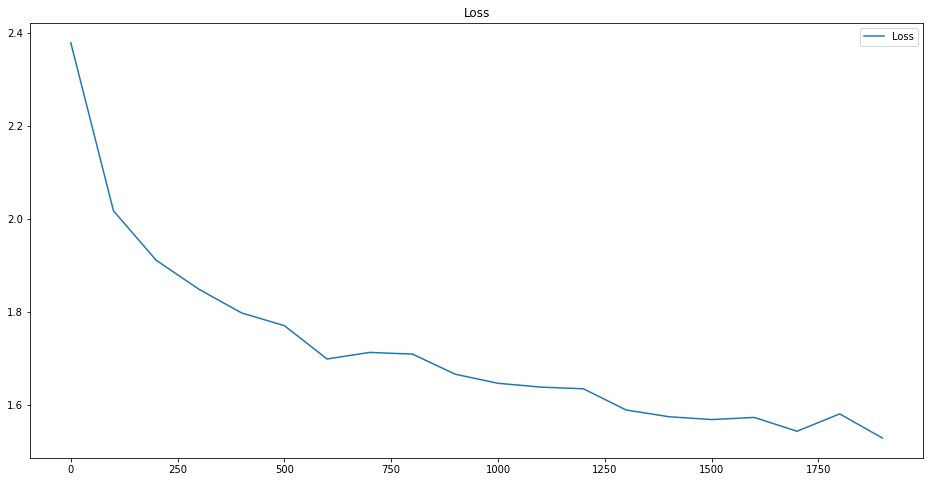

In [21]:
print(losses)

plt.figure(figsize=(16, 8))
plt.title("Loss")
plt.plot(iters, losses, label='Loss')
plt.legend()
plt.show() 

In [0]:

def generate_sample(char_rnn, seed_phrase='hello ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
    hid_state = char_rnn.initial_state()
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence)
        # print(x_sequence.shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[-1], hid_state)
        # Be really careful here with the model output
        p_next = torch.nn.functional.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([next_ix,], dtype=torch.int64)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat((x_sequence, next_ix))
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()])

In [23]:
delim = '============================'

for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print(delim + "temp = " + str(t) + delim)
  print(generate_sample(charnet, max_length=500, temperature=t))
  print('\n')

============================temp = 0.1============================
hello dead the world the still the still the world the with the see love the love the still the world the beauty the love the still the love the beauty the world the still the with the still the with the world the world the with the still the world the with the with the still the still the beauty the still the with thee my love the world the love the world the world the love the still the will the world the world the love the world the will the former the with the with the world the with the sti


============================temp = 0.2============================
hello dead, the world the still the sweet the press the lead, the still the form that thy love the world thee should me thee still the world the beauty thy beauty the form the still the can thee my love the world be they me the world the form thy sing the love the with the some the still the world the still the fair the with the find,
  the more my love the sti

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [0]:

class CharLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers_count=3):
        super(CharLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.layers_count = layers_count
        
        self.emb = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=layers_count, dropout=0.5)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        x = self.emb(x.view(1, -1))
        output, hidden = self.lstm(x.view(1, 1, -1), hidden)
        output = self.fc(output.view(1, -1))
        return output, hidden

    def initial_state(self):
        return (Variable(torch.zeros(self.layers_count, 1, self.hidden_size)),
                Variable(torch.zeros(self.layers_count, 1, self.hidden_size)))


In [51]:
layers_count = 2
hidden_size = 190
lr = 0.001
characters_count = len(tokens)


charnet_lstm = CharLSTMCell(characters_count, hidden_size, characters_count, layers_count)
optimizer_lstm = torch.optim.Adam(charnet_lstm.parameters(), lr=lr)
criterion_lstm = nn.CrossEntropyLoss()

iters, all_losses = train(charnet_lstm, optimizer_lstm, criterion_lstm, n_epochs=2000, print_every=100)











  0%|          | 0/2000 [00:00<?, ?it/s]









  0%|          | 1/2000 [00:00<10:37,  3.14it/s]









  0%|          | 2/2000 [00:00<10:43,  3.11it/s]









  0%|          | 3/2000 [00:00<10:38,  3.13it/s]









  0%|          | 4/2000 [00:01<10:43,  3.10it/s]









  0%|          | 5/2000 [00:01<10:51,  3.06it/s]









  0%|          | 6/2000 [00:01<10:49,  3.07it/s]









  0%|          | 7/2000 [00:02<10:47,  3.08it/s]









  0%|          | 8/2000 [00:02<10:43,  3.10it/s]









  0%|          | 9/2000 [00:02<10:48,  3.07it/s]









  0%|          | 10/2000 [00:03<10:49,  3.06it/s]









  1%|          | 11/2000 [00:03<10:52,  3.05it/s]









  1%|          | 12/2000 [00:03<10:49,  3.06it/s]









  1%|          | 13/2000 [00:04<10:51,  3.05it/s]









  1%|          | 14/2000 [00:04<10:51,  3.05it/s]









  1%|          | 15/2000 [00:04<10:48,  3.06it/s]









  1%|          | 16/2000 [00:05<10:47,  3.06it/s]









  1%|

[(100 5%) Loss: 2.7920]












  5%|▌         | 101/2000 [00:32<10:20,  3.06it/s]









  5%|▌         | 102/2000 [00:32<10:24,  3.04it/s]









  5%|▌         | 103/2000 [00:33<10:18,  3.07it/s]









  5%|▌         | 104/2000 [00:33<10:15,  3.08it/s]









  5%|▌         | 105/2000 [00:33<10:22,  3.05it/s]









  5%|▌         | 106/2000 [00:34<10:23,  3.04it/s]









  5%|▌         | 107/2000 [00:34<10:27,  3.02it/s]









  5%|▌         | 108/2000 [00:34<10:35,  2.98it/s]









  5%|▌         | 109/2000 [00:35<10:31,  2.99it/s]









  6%|▌         | 110/2000 [00:35<10:22,  3.03it/s]









  6%|▌         | 111/2000 [00:35<10:15,  3.07it/s]









  6%|▌         | 112/2000 [00:36<10:10,  3.09it/s]









  6%|▌         | 113/2000 [00:36<10:05,  3.12it/s]









  6%|▌         | 114/2000 [00:36<10:11,  3.09it/s]









  6%|▌         | 115/2000 [00:37<10:11,  3.08it/s]









  6%|▌         | 116/2000 [00:37<10:06,  3.11it/s]









  6%|▌         | 117/2000 [00:

[(200 10%) Loss: 2.2947]












 10%|█         | 201/2000 [01:05<09:27,  3.17it/s]









 10%|█         | 202/2000 [01:05<09:31,  3.15it/s]









 10%|█         | 203/2000 [01:05<09:34,  3.13it/s]









 10%|█         | 204/2000 [01:06<09:32,  3.14it/s]









 10%|█         | 205/2000 [01:06<09:36,  3.12it/s]









 10%|█         | 206/2000 [01:06<09:34,  3.12it/s]









 10%|█         | 207/2000 [01:06<09:32,  3.13it/s]









 10%|█         | 208/2000 [01:07<09:31,  3.13it/s]









 10%|█         | 209/2000 [01:07<09:31,  3.13it/s]









 10%|█         | 210/2000 [01:07<09:30,  3.14it/s]









 11%|█         | 211/2000 [01:08<09:37,  3.10it/s]









 11%|█         | 212/2000 [01:08<09:37,  3.10it/s]









 11%|█         | 213/2000 [01:08<09:30,  3.13it/s]









 11%|█         | 214/2000 [01:09<09:27,  3.15it/s]









 11%|█         | 215/2000 [01:09<09:26,  3.15it/s]









 11%|█         | 216/2000 [01:09<09:24,  3.16it/s]









 11%|█         | 217/2000 [01:

[(300 15%) Loss: 2.1517]












 15%|█▌        | 301/2000 [01:36<08:47,  3.22it/s]









 15%|█▌        | 302/2000 [01:37<08:47,  3.22it/s]









 15%|█▌        | 303/2000 [01:37<08:45,  3.23it/s]









 15%|█▌        | 304/2000 [01:37<08:46,  3.22it/s]









 15%|█▌        | 305/2000 [01:38<08:42,  3.24it/s]









 15%|█▌        | 306/2000 [01:38<08:41,  3.25it/s]









 15%|█▌        | 307/2000 [01:38<08:43,  3.24it/s]









 15%|█▌        | 308/2000 [01:39<08:42,  3.24it/s]









 15%|█▌        | 309/2000 [01:39<08:43,  3.23it/s]









 16%|█▌        | 310/2000 [01:39<08:42,  3.23it/s]









 16%|█▌        | 311/2000 [01:39<08:43,  3.23it/s]









 16%|█▌        | 312/2000 [01:40<08:45,  3.21it/s]









 16%|█▌        | 313/2000 [01:40<08:48,  3.19it/s]









 16%|█▌        | 314/2000 [01:40<08:49,  3.19it/s]









 16%|█▌        | 315/2000 [01:41<08:47,  3.20it/s]









 16%|█▌        | 316/2000 [01:41<08:54,  3.15it/s]









 16%|█▌        | 317/2000 [01:

[(400 20%) Loss: 2.0231]












 20%|██        | 401/2000 [02:08<08:21,  3.19it/s]









 20%|██        | 402/2000 [02:08<08:19,  3.20it/s]









 20%|██        | 403/2000 [02:08<08:17,  3.21it/s]









 20%|██        | 404/2000 [02:09<08:16,  3.21it/s]









 20%|██        | 405/2000 [02:09<08:21,  3.18it/s]









 20%|██        | 406/2000 [02:09<08:18,  3.20it/s]









 20%|██        | 407/2000 [02:09<08:19,  3.19it/s]









 20%|██        | 408/2000 [02:10<08:22,  3.17it/s]









 20%|██        | 409/2000 [02:10<08:24,  3.15it/s]









 20%|██        | 410/2000 [02:10<08:24,  3.15it/s]









 21%|██        | 411/2000 [02:11<08:24,  3.15it/s]









 21%|██        | 412/2000 [02:11<08:23,  3.16it/s]









 21%|██        | 413/2000 [02:11<08:17,  3.19it/s]









 21%|██        | 414/2000 [02:12<08:19,  3.17it/s]









 21%|██        | 415/2000 [02:12<08:18,  3.18it/s]









 21%|██        | 416/2000 [02:12<08:17,  3.19it/s]









 21%|██        | 417/2000 [02:

[(500 25%) Loss: 1.9837]












 25%|██▌       | 501/2000 [02:39<07:58,  3.13it/s]









 25%|██▌       | 502/2000 [02:40<07:59,  3.12it/s]









 25%|██▌       | 503/2000 [02:40<07:57,  3.14it/s]









 25%|██▌       | 504/2000 [02:40<07:52,  3.16it/s]









 25%|██▌       | 505/2000 [02:40<07:54,  3.15it/s]









 25%|██▌       | 506/2000 [02:41<07:52,  3.16it/s]









 25%|██▌       | 507/2000 [02:41<07:52,  3.16it/s]









 25%|██▌       | 508/2000 [02:41<07:46,  3.20it/s]









 25%|██▌       | 509/2000 [02:42<07:48,  3.18it/s]









 26%|██▌       | 510/2000 [02:42<07:46,  3.19it/s]









 26%|██▌       | 511/2000 [02:42<07:43,  3.21it/s]









 26%|██▌       | 512/2000 [02:43<07:40,  3.23it/s]









 26%|██▌       | 513/2000 [02:43<07:38,  3.24it/s]









 26%|██▌       | 514/2000 [02:43<07:39,  3.23it/s]









 26%|██▌       | 515/2000 [02:44<07:44,  3.20it/s]









 26%|██▌       | 516/2000 [02:44<07:42,  3.21it/s]









 26%|██▌       | 517/2000 [02:

[(600 30%) Loss: 1.9340]












 30%|███       | 601/2000 [03:11<07:26,  3.13it/s]









 30%|███       | 602/2000 [03:11<07:25,  3.14it/s]









 30%|███       | 603/2000 [03:11<07:22,  3.16it/s]









 30%|███       | 604/2000 [03:12<07:28,  3.11it/s]









 30%|███       | 605/2000 [03:12<07:25,  3.13it/s]









 30%|███       | 606/2000 [03:12<07:22,  3.15it/s]









 30%|███       | 607/2000 [03:13<07:27,  3.11it/s]









 30%|███       | 608/2000 [03:13<07:34,  3.07it/s]









 30%|███       | 609/2000 [03:13<07:33,  3.07it/s]









 30%|███       | 610/2000 [03:14<07:36,  3.05it/s]









 31%|███       | 611/2000 [03:14<07:32,  3.07it/s]









 31%|███       | 612/2000 [03:14<07:28,  3.09it/s]









 31%|███       | 613/2000 [03:15<07:33,  3.06it/s]









 31%|███       | 614/2000 [03:15<07:30,  3.08it/s]









 31%|███       | 615/2000 [03:15<07:34,  3.05it/s]









 31%|███       | 616/2000 [03:16<07:39,  3.01it/s]









 31%|███       | 617/2000 [03:

[(700 35%) Loss: 1.9142]












 35%|███▌      | 701/2000 [03:43<07:00,  3.09it/s]









 35%|███▌      | 702/2000 [03:43<06:59,  3.09it/s]









 35%|███▌      | 703/2000 [03:43<06:57,  3.11it/s]









 35%|███▌      | 704/2000 [03:44<06:56,  3.11it/s]









 35%|███▌      | 705/2000 [03:44<06:53,  3.13it/s]









 35%|███▌      | 706/2000 [03:44<06:52,  3.13it/s]









 35%|███▌      | 707/2000 [03:45<06:48,  3.16it/s]









 35%|███▌      | 708/2000 [03:45<06:47,  3.17it/s]









 35%|███▌      | 709/2000 [03:45<06:47,  3.17it/s]









 36%|███▌      | 710/2000 [03:46<06:47,  3.17it/s]









 36%|███▌      | 711/2000 [03:46<06:48,  3.15it/s]









 36%|███▌      | 712/2000 [03:46<06:51,  3.13it/s]









 36%|███▌      | 713/2000 [03:47<06:52,  3.12it/s]









 36%|███▌      | 714/2000 [03:47<06:49,  3.14it/s]









 36%|███▌      | 715/2000 [03:47<06:52,  3.12it/s]









 36%|███▌      | 716/2000 [03:47<06:50,  3.13it/s]









 36%|███▌      | 717/2000 [03:

[(800 40%) Loss: 1.8626]












 40%|████      | 801/2000 [04:14<06:19,  3.16it/s]









 40%|████      | 802/2000 [04:15<06:19,  3.16it/s]









 40%|████      | 803/2000 [04:15<06:19,  3.15it/s]









 40%|████      | 804/2000 [04:15<06:18,  3.16it/s]









 40%|████      | 805/2000 [04:16<06:22,  3.12it/s]









 40%|████      | 806/2000 [04:16<06:21,  3.13it/s]









 40%|████      | 807/2000 [04:16<06:18,  3.15it/s]









 40%|████      | 808/2000 [04:17<06:17,  3.16it/s]









 40%|████      | 809/2000 [04:17<06:15,  3.17it/s]









 40%|████      | 810/2000 [04:17<06:13,  3.19it/s]









 41%|████      | 811/2000 [04:18<06:12,  3.19it/s]









 41%|████      | 812/2000 [04:18<06:10,  3.20it/s]









 41%|████      | 813/2000 [04:18<06:13,  3.18it/s]









 41%|████      | 814/2000 [04:19<06:18,  3.13it/s]









 41%|████      | 815/2000 [04:19<06:13,  3.17it/s]









 41%|████      | 816/2000 [04:19<06:12,  3.17it/s]









 41%|████      | 817/2000 [04:

[(900 45%) Loss: 1.8433]












 45%|████▌     | 901/2000 [04:46<05:49,  3.15it/s]









 45%|████▌     | 902/2000 [04:46<05:46,  3.16it/s]









 45%|████▌     | 903/2000 [04:47<05:51,  3.12it/s]









 45%|████▌     | 904/2000 [04:47<05:50,  3.12it/s]









 45%|████▌     | 905/2000 [04:47<05:49,  3.13it/s]









 45%|████▌     | 906/2000 [04:47<05:47,  3.14it/s]









 45%|████▌     | 907/2000 [04:48<05:44,  3.17it/s]









 45%|████▌     | 908/2000 [04:48<05:44,  3.17it/s]









 45%|████▌     | 909/2000 [04:48<05:44,  3.17it/s]









 46%|████▌     | 910/2000 [04:49<05:40,  3.20it/s]









 46%|████▌     | 911/2000 [04:49<05:40,  3.20it/s]









 46%|████▌     | 912/2000 [04:49<05:39,  3.21it/s]









 46%|████▌     | 913/2000 [04:50<05:46,  3.14it/s]









 46%|████▌     | 914/2000 [04:50<05:51,  3.09it/s]









 46%|████▌     | 915/2000 [04:50<05:48,  3.12it/s]









 46%|████▌     | 916/2000 [04:51<05:49,  3.10it/s]









 46%|████▌     | 917/2000 [04:

[(1000 50%) Loss: 1.8100]












 50%|█████     | 1001/2000 [05:18<05:12,  3.19it/s]









 50%|█████     | 1002/2000 [05:18<05:09,  3.22it/s]









 50%|█████     | 1003/2000 [05:18<05:11,  3.20it/s]









 50%|█████     | 1004/2000 [05:19<05:15,  3.16it/s]









 50%|█████     | 1005/2000 [05:19<05:12,  3.19it/s]









 50%|█████     | 1006/2000 [05:19<05:12,  3.18it/s]









 50%|█████     | 1007/2000 [05:19<05:11,  3.19it/s]









 50%|█████     | 1008/2000 [05:20<05:07,  3.23it/s]









 50%|█████     | 1009/2000 [05:20<05:06,  3.23it/s]









 50%|█████     | 1010/2000 [05:20<05:06,  3.23it/s]









 51%|█████     | 1011/2000 [05:21<05:09,  3.20it/s]









 51%|█████     | 1012/2000 [05:21<05:11,  3.18it/s]









 51%|█████     | 1013/2000 [05:21<05:08,  3.20it/s]









 51%|█████     | 1014/2000 [05:22<05:08,  3.19it/s]









 51%|█████     | 1015/2000 [05:22<05:07,  3.21it/s]









 51%|█████     | 1016/2000 [05:22<05:10,  3.17it/s]









 51%|█████    

[(1100 55%) Loss: 1.7982]












 55%|█████▌    | 1101/2000 [05:49<04:54,  3.05it/s]









 55%|█████▌    | 1102/2000 [05:50<04:57,  3.02it/s]









 55%|█████▌    | 1103/2000 [05:50<04:55,  3.03it/s]









 55%|█████▌    | 1104/2000 [05:50<04:53,  3.05it/s]









 55%|█████▌    | 1105/2000 [05:51<04:54,  3.04it/s]









 55%|█████▌    | 1106/2000 [05:51<04:58,  2.99it/s]









 55%|█████▌    | 1107/2000 [05:51<04:56,  3.02it/s]









 55%|█████▌    | 1108/2000 [05:52<04:53,  3.04it/s]









 55%|█████▌    | 1109/2000 [05:52<04:53,  3.04it/s]









 56%|█████▌    | 1110/2000 [05:52<04:57,  2.99it/s]









 56%|█████▌    | 1111/2000 [05:53<04:57,  2.99it/s]









 56%|█████▌    | 1112/2000 [05:53<04:53,  3.03it/s]









 56%|█████▌    | 1113/2000 [05:53<04:47,  3.09it/s]









 56%|█████▌    | 1114/2000 [05:54<04:47,  3.08it/s]









 56%|█████▌    | 1115/2000 [05:54<04:46,  3.09it/s]









 56%|█████▌    | 1116/2000 [05:54<04:42,  3.13it/s]









 56%|█████▌   

[(1200 60%) Loss: 1.7680]












 60%|██████    | 1201/2000 [06:21<04:08,  3.22it/s]









 60%|██████    | 1202/2000 [06:21<04:07,  3.22it/s]









 60%|██████    | 1203/2000 [06:22<04:11,  3.17it/s]









 60%|██████    | 1204/2000 [06:22<04:10,  3.18it/s]









 60%|██████    | 1205/2000 [06:22<04:11,  3.16it/s]









 60%|██████    | 1206/2000 [06:23<04:11,  3.15it/s]









 60%|██████    | 1207/2000 [06:23<04:11,  3.15it/s]









 60%|██████    | 1208/2000 [06:23<04:07,  3.20it/s]









 60%|██████    | 1209/2000 [06:23<04:07,  3.20it/s]









 60%|██████    | 1210/2000 [06:24<04:07,  3.19it/s]









 61%|██████    | 1211/2000 [06:24<04:06,  3.20it/s]









 61%|██████    | 1212/2000 [06:24<04:06,  3.19it/s]









 61%|██████    | 1213/2000 [06:25<04:06,  3.20it/s]









 61%|██████    | 1214/2000 [06:25<04:05,  3.20it/s]









 61%|██████    | 1215/2000 [06:25<04:06,  3.18it/s]









 61%|██████    | 1216/2000 [06:26<04:06,  3.18it/s]









 61%|██████   

[(1300 65%) Loss: 1.7723]












 65%|██████▌   | 1301/2000 [06:52<03:48,  3.06it/s]









 65%|██████▌   | 1302/2000 [06:53<03:48,  3.05it/s]









 65%|██████▌   | 1303/2000 [06:53<03:47,  3.06it/s]









 65%|██████▌   | 1304/2000 [06:53<03:49,  3.03it/s]









 65%|██████▌   | 1305/2000 [06:54<03:48,  3.04it/s]









 65%|██████▌   | 1306/2000 [06:54<03:46,  3.06it/s]









 65%|██████▌   | 1307/2000 [06:54<03:44,  3.09it/s]









 65%|██████▌   | 1308/2000 [06:55<03:43,  3.10it/s]









 65%|██████▌   | 1309/2000 [06:55<03:41,  3.12it/s]









 66%|██████▌   | 1310/2000 [06:55<03:41,  3.11it/s]









 66%|██████▌   | 1311/2000 [06:56<03:42,  3.10it/s]









 66%|██████▌   | 1312/2000 [06:56<03:43,  3.08it/s]









 66%|██████▌   | 1313/2000 [06:56<03:43,  3.08it/s]









 66%|██████▌   | 1314/2000 [06:57<03:41,  3.10it/s]









 66%|██████▌   | 1315/2000 [06:57<03:43,  3.07it/s]









 66%|██████▌   | 1316/2000 [06:57<03:40,  3.10it/s]









 66%|██████▌  

[(1400 70%) Loss: 1.7425]












 70%|███████   | 1401/2000 [07:24<03:09,  3.17it/s]









 70%|███████   | 1402/2000 [07:24<03:08,  3.18it/s]









 70%|███████   | 1403/2000 [07:25<03:07,  3.19it/s]









 70%|███████   | 1404/2000 [07:25<03:05,  3.21it/s]









 70%|███████   | 1405/2000 [07:25<03:06,  3.18it/s]









 70%|███████   | 1406/2000 [07:26<03:04,  3.22it/s]









 70%|███████   | 1407/2000 [07:26<03:02,  3.24it/s]









 70%|███████   | 1408/2000 [07:26<03:03,  3.22it/s]









 70%|███████   | 1409/2000 [07:27<03:03,  3.22it/s]









 70%|███████   | 1410/2000 [07:27<03:02,  3.23it/s]









 71%|███████   | 1411/2000 [07:27<03:03,  3.21it/s]









 71%|███████   | 1412/2000 [07:28<03:03,  3.20it/s]









 71%|███████   | 1413/2000 [07:28<03:03,  3.20it/s]









 71%|███████   | 1414/2000 [07:28<03:03,  3.20it/s]









 71%|███████   | 1415/2000 [07:29<03:04,  3.16it/s]









 71%|███████   | 1416/2000 [07:29<03:04,  3.17it/s]









 71%|███████  

[(1500 75%) Loss: 1.7240]












 75%|███████▌  | 1501/2000 [07:56<02:39,  3.14it/s]









 75%|███████▌  | 1502/2000 [07:56<02:37,  3.15it/s]









 75%|███████▌  | 1503/2000 [07:56<02:37,  3.16it/s]









 75%|███████▌  | 1504/2000 [07:57<02:36,  3.17it/s]









 75%|███████▌  | 1505/2000 [07:57<02:36,  3.17it/s]









 75%|███████▌  | 1506/2000 [07:57<02:37,  3.14it/s]









 75%|███████▌  | 1507/2000 [07:58<02:38,  3.12it/s]









 75%|███████▌  | 1508/2000 [07:58<02:38,  3.10it/s]









 75%|███████▌  | 1509/2000 [07:58<02:38,  3.11it/s]









 76%|███████▌  | 1510/2000 [07:59<02:36,  3.13it/s]









 76%|███████▌  | 1511/2000 [07:59<02:36,  3.13it/s]









 76%|███████▌  | 1512/2000 [07:59<02:35,  3.14it/s]









 76%|███████▌  | 1513/2000 [08:00<02:33,  3.16it/s]









 76%|███████▌  | 1514/2000 [08:00<02:33,  3.17it/s]









 76%|███████▌  | 1515/2000 [08:00<02:32,  3.17it/s]









 76%|███████▌  | 1516/2000 [08:01<02:32,  3.18it/s]









 76%|███████▌ 

[(1600 80%) Loss: 1.6948]












 80%|████████  | 1601/2000 [08:28<02:08,  3.10it/s]









 80%|████████  | 1602/2000 [08:28<02:07,  3.11it/s]









 80%|████████  | 1603/2000 [08:28<02:07,  3.11it/s]









 80%|████████  | 1604/2000 [08:29<02:07,  3.11it/s]









 80%|████████  | 1605/2000 [08:29<02:06,  3.12it/s]









 80%|████████  | 1606/2000 [08:29<02:07,  3.10it/s]









 80%|████████  | 1607/2000 [08:29<02:06,  3.12it/s]









 80%|████████  | 1608/2000 [08:30<02:05,  3.12it/s]









 80%|████████  | 1609/2000 [08:30<02:05,  3.11it/s]









 80%|████████  | 1610/2000 [08:30<02:05,  3.10it/s]









 81%|████████  | 1611/2000 [08:31<02:04,  3.13it/s]









 81%|████████  | 1612/2000 [08:31<02:04,  3.12it/s]









 81%|████████  | 1613/2000 [08:31<02:04,  3.11it/s]









 81%|████████  | 1614/2000 [08:32<02:03,  3.13it/s]









 81%|████████  | 1615/2000 [08:32<02:02,  3.14it/s]









 81%|████████  | 1616/2000 [08:32<02:02,  3.14it/s]









 81%|████████ 

[(1700 85%) Loss: 1.6997]












 85%|████████▌ | 1701/2000 [08:59<01:34,  3.18it/s]









 85%|████████▌ | 1702/2000 [08:59<01:32,  3.21it/s]









 85%|████████▌ | 1703/2000 [09:00<01:32,  3.20it/s]









 85%|████████▌ | 1704/2000 [09:00<01:31,  3.23it/s]









 85%|████████▌ | 1705/2000 [09:00<01:32,  3.19it/s]









 85%|████████▌ | 1706/2000 [09:01<01:31,  3.20it/s]









 85%|████████▌ | 1707/2000 [09:01<01:32,  3.18it/s]









 85%|████████▌ | 1708/2000 [09:01<01:30,  3.21it/s]









 85%|████████▌ | 1709/2000 [09:02<01:30,  3.23it/s]









 86%|████████▌ | 1710/2000 [09:02<01:29,  3.23it/s]









 86%|████████▌ | 1711/2000 [09:02<01:29,  3.23it/s]









 86%|████████▌ | 1712/2000 [09:02<01:28,  3.24it/s]









 86%|████████▌ | 1713/2000 [09:03<01:28,  3.25it/s]









 86%|████████▌ | 1714/2000 [09:03<01:28,  3.25it/s]









 86%|████████▌ | 1715/2000 [09:03<01:27,  3.26it/s]









 86%|████████▌ | 1716/2000 [09:04<01:27,  3.24it/s]









 86%|████████▌

[(1800 90%) Loss: 1.6876]












 90%|█████████ | 1801/2000 [09:30<01:02,  3.17it/s]









 90%|█████████ | 1802/2000 [09:31<01:01,  3.20it/s]









 90%|█████████ | 1803/2000 [09:31<01:01,  3.19it/s]









 90%|█████████ | 1804/2000 [09:31<01:01,  3.21it/s]









 90%|█████████ | 1805/2000 [09:32<01:01,  3.19it/s]









 90%|█████████ | 1806/2000 [09:32<01:00,  3.20it/s]









 90%|█████████ | 1807/2000 [09:32<01:00,  3.20it/s]









 90%|█████████ | 1808/2000 [09:33<00:59,  3.21it/s]









 90%|█████████ | 1809/2000 [09:33<00:59,  3.23it/s]









 90%|█████████ | 1810/2000 [09:33<00:58,  3.23it/s]









 91%|█████████ | 1811/2000 [09:34<00:58,  3.22it/s]









 91%|█████████ | 1812/2000 [09:34<00:58,  3.24it/s]









 91%|█████████ | 1813/2000 [09:34<00:57,  3.25it/s]









 91%|█████████ | 1814/2000 [09:35<00:57,  3.25it/s]









 91%|█████████ | 1815/2000 [09:35<00:56,  3.27it/s]









 91%|█████████ | 1816/2000 [09:35<00:56,  3.28it/s]









 91%|█████████

[(1900 95%) Loss: 1.6892]












 95%|█████████▌| 1901/2000 [10:02<00:31,  3.15it/s]









 95%|█████████▌| 1902/2000 [10:02<00:30,  3.17it/s]









 95%|█████████▌| 1903/2000 [10:02<00:30,  3.20it/s]









 95%|█████████▌| 1904/2000 [10:03<00:30,  3.15it/s]









 95%|█████████▌| 1905/2000 [10:03<00:30,  3.16it/s]









 95%|█████████▌| 1906/2000 [10:03<00:29,  3.15it/s]









 95%|█████████▌| 1907/2000 [10:04<00:29,  3.17it/s]









 95%|█████████▌| 1908/2000 [10:04<00:28,  3.18it/s]









 95%|█████████▌| 1909/2000 [10:04<00:28,  3.20it/s]









 96%|█████████▌| 1910/2000 [10:05<00:28,  3.21it/s]









 96%|█████████▌| 1911/2000 [10:05<00:27,  3.20it/s]









 96%|█████████▌| 1912/2000 [10:05<00:27,  3.18it/s]









 96%|█████████▌| 1913/2000 [10:06<00:27,  3.20it/s]









 96%|█████████▌| 1914/2000 [10:06<00:26,  3.20it/s]









 96%|█████████▌| 1915/2000 [10:06<00:26,  3.22it/s]









 96%|█████████▌| 1916/2000 [10:07<00:26,  3.17it/s]









 96%|█████████

[(2000 100%) Loss: 1.6547]


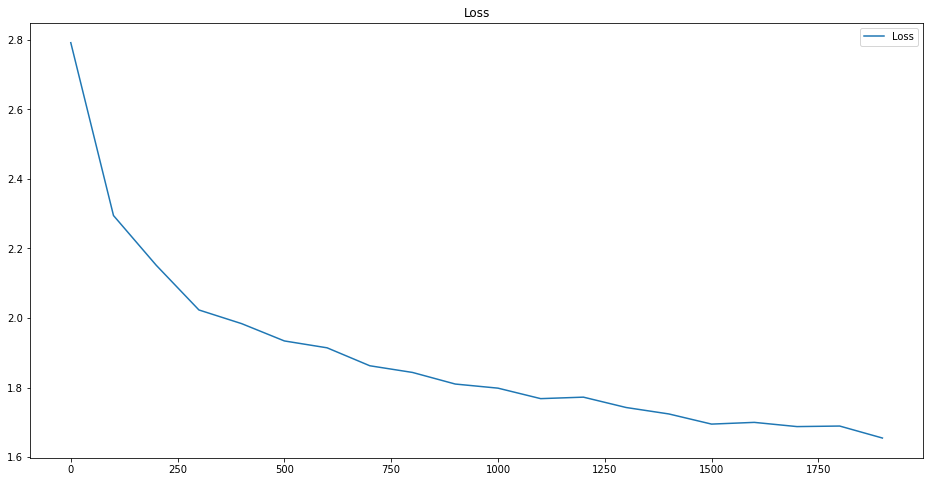

In [52]:
plt.figure(figsize=(16, 8))
plt.title("Loss")
plt.plot(iters, all_losses, label='Loss')
plt.legend()
plt.show() 

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [57]:
delim = '============================'

for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print(delim + "temp = " + str(t) + delim)
  print(generate_sample(charnet, max_length=500, temperature=t))
  print('\n')
  

============================temp = 0.1============================
hello see the sumpent,
  and the the the the sun the see the stay,
  and thee the sull the self the self the sees the so my seess,
  and the shall the sum the shall the such the see thee stars the shear the self the sund thee the sunder the sees,
  and the straise the shall the such self thee thee the shall the self thee thee the self thee the stare thee thee the stard,
    and the stare the shall thee the stard thee the sull stard the stay,
  and the self the stare the sumself the self thee the


============================temp = 0.2============================
hello stand dear thee the sheest the stand,
    the sun the some the with thee thee self the see thee thee the self thee thee,
    and thee the weet the beauty shall the self the shall shall thee will the stars the sing,
    the see the the so me sun thee in the sell the seest thee,
  the sumpers the spart the start thee thee shall thee thee a the shall the see

Сделанные на LSTM стихи выглядят поэтичнее, с большим чувством рифмы и более человечными. 
Это и понятно, потому что LSTM в отличие от RNN лучше улавливает продолжительный контекст (смысловой сюжет так сказать). Да и лос у LSTM был ниже.
  

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import pickle
with open('/content/drive/My Drive/lstm_charnet.pickle', 'wb') as file:
    pickle.dump(charnet_lstm, file)

with open('/content/drive/My Drive/lstm_charnet.pickle', 'rb') as file:
    charnet = pickle.load(file)
    print(generate_sample(charnet_lstm, max_length=500, temperature=0.5))

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


hello that when i lank glasss dear in lead;
  and with whe the trues thee be thou more shall me with thee;
  so have with she to the day stell, the heart;
  thine all then me of the were the the with far farth shall speen;
  so beauty the consoud mate love one that have with your my stars will then sumpers to doth all ands they will the stains.
     so when the shall of my in my sell prose of when thee
    in the part with weet that the the leave the stressed to gomed with lorge all the deasing 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)